In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

from nn.src.Layers import ReLU, PReLU, LeakyReLU, ELU, SELU, Sigmoid, Tanh, LinearLayer, RReLU, Softmax
from nn.src.Losses import MSE, CrossEntropyLoss
from nn.src.Networks import MLP
from nn.src.Optimizers import Adam
from nn.src.utils import ScalingTransformer, DataLoader
from time import time

os.chdir("..")

In [6]:
transformer = ScalingTransformer()
scaler = StandardScaler()
df_train, df_test = pd.read_csv("../mio1/regression/multimodal-large-training.csv"), pd.read_csv("../mio1/regression/multimodal-large-test.csv")
X_full_train = scaler.fit_transform(np.asarray(df_train["x"]).reshape(-1,1))
X_full_test = scaler.transform(np.asarray(df_test["x"]).reshape(-1,1))
y_full_train = transformer.fit_transform(np.asarray(df_train["y"]))
y_full_test = transformer.transform(np.asarray(df_test["y"]))
dataloader = DataLoader(X_full_train,y_full_train, batch_size=100)

In [16]:
def test_convergence_rate(loss_threshold = 1, max_epochs =10 ** 5, lr = 0.1):
    initialisation = [
        {"activation": ReLU, "dist" : "uniform", "var" : "He"},
        {"activation": PReLU, "dist" : "uniform", "var" : "He"},
        {"activation": LeakyReLU, "dist" : "uniform", "var" : "He"},
        {"activation": ELU, "dist" : "uniform", "var" : "He"},
        {"activation": SELU, "dist" : "normal", "var" : "Lecun"},
        {"activation": Sigmoid, "dist" : "uniform", "var" : "Glorot"},
        {"activation": Tanh, "dist" : "uniform", "var" : "Glorot"},
    ]
    results = pd.DataFrame(columns=["activation", "epochs", "train_loss", "test_loss", "finished", "time"])

    for dictionary in initialisation:
        activation = dictionary["activation"]
        dist = dictionary["dist"]
        var = dictionary["var"]
        print(activation.__name__)
        layers  = [LinearLayer(1,5, dist=dist, var=var),
                activation(),
                LinearLayer(5,5, dist=dist, var=var),
                activation(),
                LinearLayer(5,1, dist=dist, var=var)
                ]
        net = MLP(layers)
        loss = MSE()
        optim = Adam(net.layers, lr)
        start = time()
        for epoch in range(max_epochs):
            for (X,y) in dataloader:
                y_hat = net(X)
                err = loss(y,y_hat)
                gradient = loss.derriv()
                net.backward(gradient)
                optim.step()
            net.set_train(False)
            test_err = loss(y_full_test, net(X_full_test))
            if test_err < loss_threshold:
                train_err = loss(y_full_train, net(X_full_train))
                end = time()
                results.loc[len(results)] = [activation.__name__, epoch, train_err, test_err, True, end-start]
                break
        else: # if the for loop didn't break
            train_err = loss(y_full_train, net(X_full_train))
            end = time()
            results.loc[len(results)] = [activation.__name__, epoch, train_err, test_err, False, end-start]
    return results




In [4]:
def test_learning_time(epochs = 100):
    activations = [ReLU, PReLU, LeakyReLU, ELU, SELU , Sigmoid, Tanh]
    results = pd.DataFrame(columns=["activation", "time"])

    for activation in activations:
        start = time()
        print(activation.__name__)
        layers  = [LinearLayer(1,5),
                activation(),
                LinearLayer(5,5),
                activation(),
                LinearLayer(5,1),
                ]
        net = MLP(layers)
        loss = MSE()
        optim = Adam(net.layers, 0.1)
        for epoch in range(epochs):
            for (X,y) in dataloader:
                y_hat = net(X)
                err = loss(y,y_hat)
                gradient = loss.derriv()
                net.backward(gradient)
                optim.step()
        end = time()
        results.loc[len(results)] = [activation.__name__, end-start]
    return results


In [5]:
def test_interference_time(iterations = 10**6, size_in = (100,100)):
    activations = [ReLU, PReLU, LeakyReLU, ELU, SELU , Sigmoid, Tanh]
    results = pd.DataFrame(columns=["activation", "time"])
    input = np.random.rand(*size_in)
    for activation in activations:
        layer = activation()
        start = time()
        print(activation.__name__)
        for i in range(iterations):
            layer(input)
        end = time()
        results.loc[len(results)] = [activation.__name__, end-start]
    return results


In [19]:
df = test_convergence_rate(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1)

ReLU
PReLU
LeakyReLU
ELU
SELU
Sigmoid
Tanh


In [20]:
df

,activation,epochs,train_loss,test_loss,finished,time
0,ReLU,999,0.521608,0.526146,False,18.381239
1,PReLU,0,0.088042,0.085972,True,0.024631
2,LeakyReLU,50,0.093552,0.094696,True,0.938759
3,ELU,12,0.066950,0.067606,True,0.247217
4,SELU,7,0.088056,0.093037,True,0.151035
5,Sigmoid,111,0.037198,0.041391,True,2.004622
6,Tanh,6,0.092400,0.099788,True,0.145368


In [21]:
df = test_learning_time(epochs=1000)

ReLU
PReLU
LeakyReLU
ELU
SELU
Sigmoid
Tanh


In [22]:
df

,activation,time
0,ReLU,17.052810
1,PReLU,20.209093
2,LeakyReLU,15.666067
3,ELU,17.304827
4,SELU,17.586321
5,Sigmoid,15.586730
6,Tanh,16.711779


In [24]:
df = test_interference_time(iterations=10**6, size_in=(100,100))

ReLU
PReLU
LeakyReLU
ELU
SELU
Sigmoid
Tanh


In [25]:
df

,activation,time
0,ReLU,13.233905
1,PReLU,15.341656
2,LeakyReLU,15.334602
3,ELU,63.733897
4,SELU,65.790686
5,Sigmoid,58.884090
6,Tanh,108.204767


In [27]:
df.to_csv("inference_time.csv")

In [7]:
def test_convergence_rate2(loss_threshold = 1, max_epochs =10 ** 5, lr = 0.1):
    initialisation = [
        {"activation": ReLU, "dist" : "uniform", "var" : "He"},
        {"activation": PReLU, "dist" : "uniform", "var" : "He"},
        {"activation": LeakyReLU, "dist" : "uniform", "var" : "He"},
        {"activation": RReLU, "dist" : "uniform", "var" : "He"},
        {"activation": ELU, "dist" : "uniform", "var" : "He"},
        {"activation": SELU, "dist" : "normal", "var" : "Lecun"},
        {"activation": Sigmoid, "dist" : "uniform", "var" : "Glorot"},
        {"activation": Tanh, "dist" : "uniform", "var" : "Glorot"},
    ]
    results = pd.DataFrame(columns=["activation", "epochs", "train_loss", "test_loss", "finished", "time"])

    for dictionary in initialisation:
        activation = dictionary["activation"]
        dist = dictionary["dist"]
        var = dictionary["var"]
        print(activation.__name__)
        layers  = [LinearLayer(1,5, dist=dist, var=var),
                   activation(),
                   LinearLayer(5,1, dist=dist, var=var)
                   ]
        net = MLP(layers)
        loss = MSE()
        optim = Adam(net.layers, lr)
        start = time()
        for epoch in range(max_epochs):
            for (X,y) in dataloader:
                y_hat = net(X)
                err = loss(y,y_hat)
                gradient = loss.derriv()
                net.backward(gradient)
                optim.step()
            net.set_train(False)
            test_err = loss(y_full_test, net(X_full_test))
            if test_err < loss_threshold:
                train_err = loss(y_full_train, net(X_full_train))
                end = time()
                results.loc[len(results)] = [activation.__name__, epoch, train_err, test_err, True, end-start]
                break
        else: # if the for loop didn't break
            train_err = loss(y_full_train, net(X_full_train))
            end = time()
            results.loc[len(results)] = [activation.__name__, epoch, train_err, test_err, False, end-start]
    return results




In [8]:
test_convergence_rate2(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1)

ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


,activation,epochs,train_loss,test_loss,finished,time
0,ReLU,999,0.325190,0.330777,False,14.839837
1,PReLU,999,0.121782,0.121190,False,18.217031
2,LeakyReLU,999,0.173542,0.170413,False,16.167088
3,RReLU,223,0.085294,0.089489,True,2.858466
4,ELU,69,0.096781,0.099310,True,1.047277
5,SELU,483,0.095037,0.097442,True,7.773095
6,Sigmoid,52,0.096182,0.099871,True,0.688372
7,Tanh,5,0.091680,0.095857,True,0.085678


In [12]:
def test_convergence_rate3(loss_threshold = 1, max_epochs =10 ** 5, lr = 0.1):
    initialisation = [
        {"activation": ReLU, "dist" : "uniform", "var" : "He"},
        {"activation": PReLU, "dist" : "uniform", "var" : "He"},
        {"activation": LeakyReLU, "dist" : "uniform", "var" : "He"},
        {"activation": RReLU, "dist" : "uniform", "var" : "He"},
        {"activation": ELU, "dist" : "uniform", "var" : "He"},
        {"activation": SELU, "dist" : "normal", "var" : "Lecun"},
        {"activation": Sigmoid, "dist" : "uniform", "var" : "Glorot"},
        {"activation": Tanh, "dist" : "uniform", "var" : "Glorot"},
    ]
    results = pd.DataFrame(columns=["activation", "epochs", "train_loss", "test_loss", "finished", "time"])

    for dictionary in initialisation:
        activation = dictionary["activation"]
        dist = dictionary["dist"]
        var = dictionary["var"]
        print(activation.__name__)
        layers  = [LinearLayer(1,5, dist=dist, var=var),
                   activation(),
                   LinearLayer(5, 5, dist=dist, var=var),
                   activation(),
                   LinearLayer(5, 5, dist=dist, var=var),
                   activation(),
                   LinearLayer(5, 5, dist=dist, var=var),
                   activation(),
                   LinearLayer(5, 5, dist=dist, var=var),
                   activation(),
                   LinearLayer(5, 5, dist=dist, var=var),
                   activation(),
                   LinearLayer(5, 5, dist=dist, var=var),
                   activation(),
                   LinearLayer(5,1, dist=dist, var=var)
                   ]
        net = MLP(layers)
        loss = MSE()
        optim = Adam(net.layers, lr)
        start = time()
        for epoch in range(max_epochs):
            for (X,y) in dataloader:
                y_hat = net(X)
                err = loss(y,y_hat)
                gradient = loss.derriv()
                net.backward(gradient)
                optim.step()
            net.set_train(False)
            test_err = loss(y_full_test, net(X_full_test))
            if test_err < loss_threshold:
                train_err = loss(y_full_train, net(X_full_train))
                end = time()
                results.loc[len(results)] = [activation.__name__, epoch, train_err, test_err, True, end-start]
                break
        else: # if the for loop didn't break
            train_err = loss(y_full_train, net(X_full_train))
            end = time()
            results.loc[len(results)] = [activation.__name__, epoch, train_err, test_err, False, end-start]
    return results



In [13]:
results = pd.DataFrame(columns=["activation", "epochs", "train_loss", "test_loss", "finished", "time"])
for i in range(10):
    print(i)
    results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))

0
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


1
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


2
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


3
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


4
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


5
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


6
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


7
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU


/home/pawel/studia/MIOwAD/MIOwAD_labs/nn/src.py:340: RuntimeWarning: overflow encountered in exp
  return self.scale * np.where(X < 0, self.alpha * (np.exp(X) - 1), X)
/home/pawel/studia/MIOwAD/MIOwAD_labs/nn/src.py:343: RuntimeWarning: overflow encountered in exp
  return self.scale * np.where(self.last_in < 0, self.alpha * np.exp(self.last_in), 1) * next_gradient
/home/pawel/studia/MIOwAD/MIOwAD_labs/nn/src.py:340: RuntimeWarning: overflow encountered in multiply
  return self.scale * np.where(X < 0, self.alpha * (np.exp(X) - 1), X)
/home/pawel/studia/MIOwAD/MIOwAD_labs/nn/src.py:343: RuntimeWarning: overflow encountered in multiply
  return self.scale * np.where(self.last_in < 0, self.alpha * np.exp(self.last_in), 1) * next_gradient


Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


8
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


9
ReLU
PReLU
LeakyReLU
RReLU
ELU
SELU
Sigmoid
Tanh


/tmp/ipykernel_57183/2324612701.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test_convergence_rate3(loss_threshold= 0.1, max_epochs=10 ** 3, lr = 0.1))


In [11]:
results

,activation,epochs,train_loss,test_loss,finished,time
0,ELU,1,0.050833,0.05449,True,0.111738
0,ELU,6,0.046085,0.049341,True,0.360182
0,ELU,999,0.524649,0.528778,False,63.260288
0,ELU,2,0.057579,0.061833,True,0.182323
0,ELU,999,0.52303,0.527247,False,67.865269
0,ELU,6,0.051617,0.055108,True,0.502525
0,ELU,2,0.05286,0.05693,True,0.240874
0,ELU,16,0.054483,0.057039,True,1.208321
0,ELU,15,0.088063,0.090536,True,1.005611
0,ELU,88,0.098742,0.099875,True,5.837771


In [14]:
results

,activation,epochs,train_loss,test_loss,finished,time
0,ReLU,999,0.522065,0.526357,False,50.658245
1,PReLU,13,0.050133,0.051589,True,0.961577
2,LeakyReLU,49,0.085973,0.089225,True,2.752059
3,RReLU,16,0.100739,0.099932,True,1.05681
4,ELU,1,0.06713,0.068843,True,0.116917
...,...,...,...,...,...,...
3,RReLU,66,0.084344,0.086436,True,3.30719
4,ELU,1,0.068936,0.070935,True,0.115829
5,SELU,2,0.036884,0.041116,True,0.185845
6,Sigmoid,999,0.521805,0.526125,False,44.886156


In [17]:
transformer = ScalingTransformer()
scaler = StandardScaler()
df_train, df_test = pd.read_csv("../mio1/regression/steps-large-training.csv"), pd.read_csv("../mio1/regression/steps-large-test.csv")
X_full_train = scaler.fit_transform(np.asarray(df_train["x"]).reshape(-1,1))
X_full_test = scaler.transform(np.asarray(df_test["x"]).reshape(-1,1))
y_full_train = transformer.fit_transform(np.asarray(df_train["y"]))
y_full_test = transformer.transform(np.asarray(df_test["y"]))
dataloader = DataLoader(X_full_train,y_full_train, batch_size=100)

0 456.3986747854806


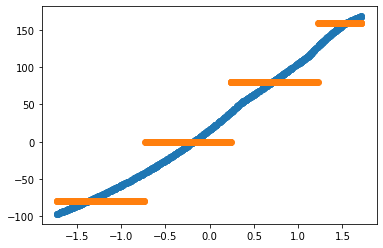

1000 158.19255966387612


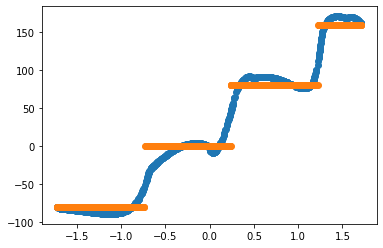

2000 108.16912284252967


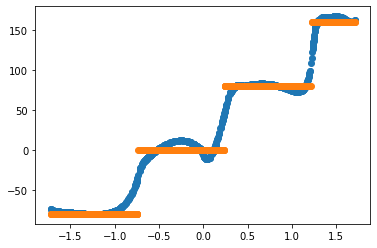

3000 124.48189211248584


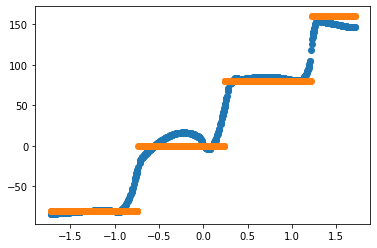

4000 65.90357515984482


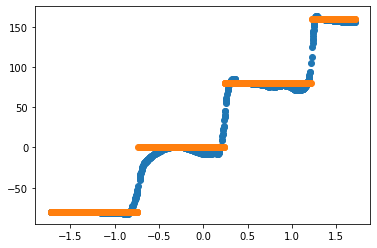

5000 87.64781088454448


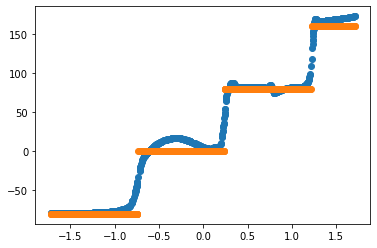

6000 55.51952342367855


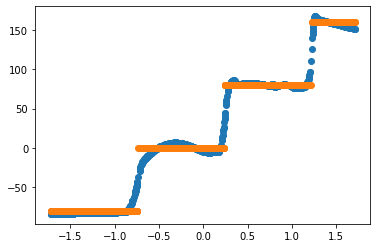

7000 70.42297246660772


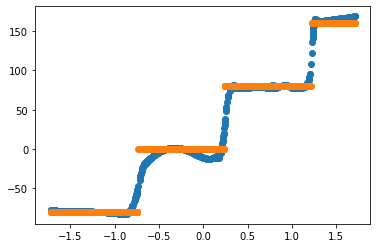

8000 61.25464322012727


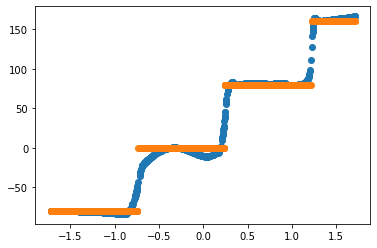

9000 79.56828578206623


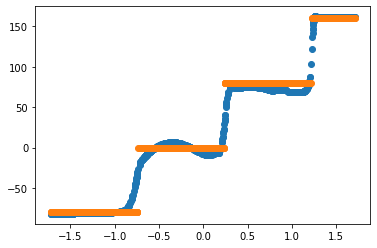

10000 144.73722467665405


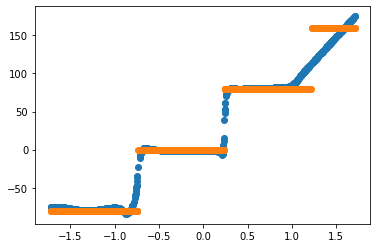

11000 51.92562054068428


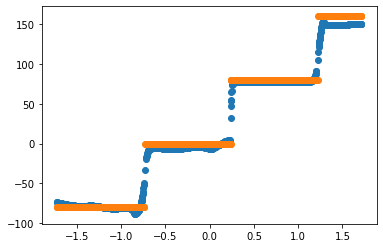

KeyboardInterrupt: 

In [18]:
layers = [
    LinearLayer(1,5, dist="normal", var="Lecun"),
    SELU(),
    LinearLayer(5, 5, dist="normal", var="Lecun"),
    SELU(),
    LinearLayer(5, 1, dist="normal", var="Lecun")

]
net = MLP(layers)
mse = MSE()
optim = Adam(net.layers, lr=0.1)
for epoch in range(10**6):
    for (X,y) in dataloader:
        y_hat = net(X)
        err = mse(y,y_hat)
        gradient = mse.derriv()
        net.backward(gradient)
        optim.step()
    if not epoch % 1000:
        plt.cla()
        print(epoch, mse(transformer.inverse_transform(y_full_test), transformer.inverse_transform(net(X_full_test))))
        plt.scatter(X_full_test, transformer.inverse_transform(net(X_full_test)))
        plt.scatter(X_full_test, transformer.inverse_transform(y_full_test))
        plt.show()

0 339.9253942129087


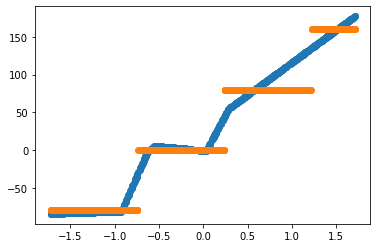

1000 143.8391080636722


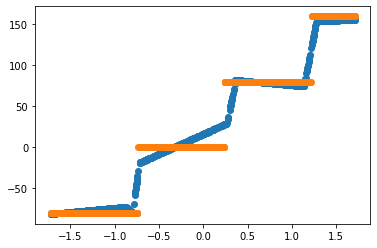

2000 98.34855141061999


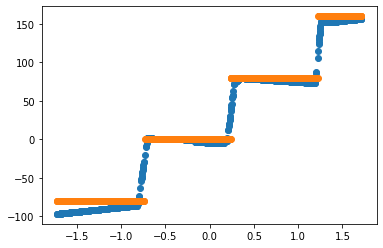

3000 26.640034769424346


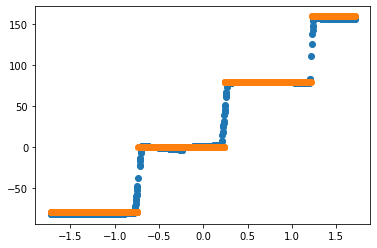

KeyboardInterrupt: 

In [19]:
layers = [
    LinearLayer(1,5, dist="normal", var="He"),
    PReLU(),
    LinearLayer(5, 5, dist="normal", var="He"),
    PReLU(),
    LinearLayer(5, 1, dist="normal", var="He")

]
net = MLP(layers)
mse = MSE()
optim = Adam(net.layers, lr=0.1)
for epoch in range(10**6):
    for (X,y) in dataloader:
        y_hat = net(X)
        err = mse(y,y_hat)
        gradient = mse.derriv()
        net.backward(gradient)
        optim.step()
    if not epoch % 1000:
        plt.cla()
        print(epoch, mse(transformer.inverse_transform(y_full_test), transformer.inverse_transform(net(X_full_test))))
        plt.scatter(X_full_test, transformer.inverse_transform(net(X_full_test)))
        plt.scatter(X_full_test, transformer.inverse_transform(y_full_test))
        plt.show()

0 0.506


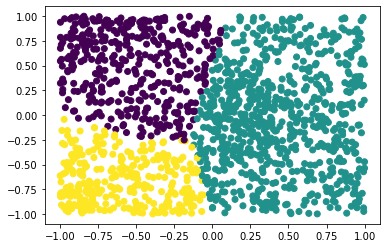

1000 0.9185


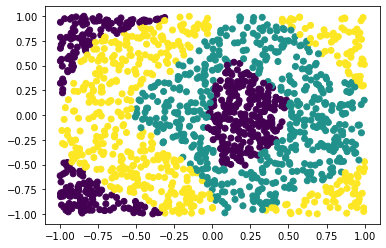

2000 0.9175


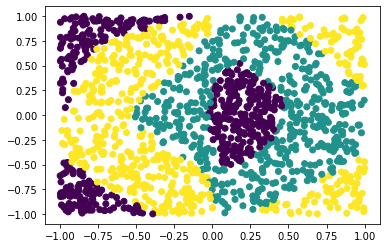

KeyboardInterrupt: 

In [44]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

df_train, df_test = pd.read_csv("../mio1/classification/rings3-regular-training.csv"), pd.read_csv("../mio1/classification/rings3-regular-test.csv")
X_full_train, X_full_test = np.asarray(df_train.loc[:,("x","y")])/100, np.asarray(df_test.loc[:, ("x","y")]) / 100
y_full_train, y_full_test = np.asarray(df_train["c"]), np.asarray(df_test["c"])
encoder = OneHotEncoder(sparse = False)
y_full_train = encoder.fit_transform(y_full_train.reshape(-1, 1))
y_full_test = encoder.transform(y_full_test.reshape(-1, 1))
dataloader = DataLoader(X_full_train,y_full_train, batch_size=100)

layers = [
    LinearLayer(2,5, dist="normal", var="Lecun"),
    SELU(),
    LinearLayer(5, 5, dist="normal", var="Lecun"),
    SELU(),
    LinearLayer(5, 3, dist="normal", var="Lecun"),
    Softmax(),

]
loss = CrossEntropyLoss()
net = MLP(layers)
optim = Adam(net.layers, lr=0.1)
for epoch in range(10**6):
    for (X,y) in dataloader:
        y_hat = net(X)
        err = loss(y,y_hat)
        gradient = loss.derriv()
        net.backward(gradient)
        optim.step()
    if not epoch % 1000:
        plt.cla()
        print(epoch, f1_score(np.argmax(y_full_test, axis=1), np.argmax(net(X_full_test), axis = 1), average = "micro") )
        plt.scatter(X_full_train[:,0], X_full_train[:,1], c= np.argmax(net(X_full_train), axis = 1))
        plt.show()

0 0.49050000000000005


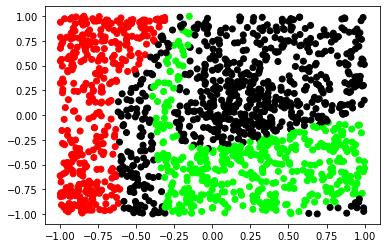

1000 0.951


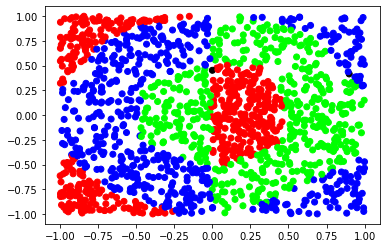

2000 0.9455


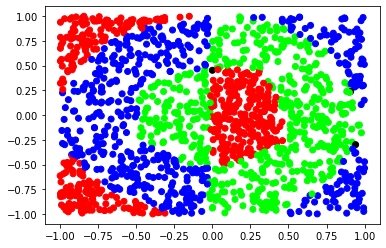

KeyboardInterrupt: 

In [23]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

df_train, df_test = pd.read_csv("../mio1/classification/rings3-regular-training.csv"), pd.read_csv("../mio1/classification/rings3-regular-test.csv")
X_full_train, X_full_test = np.asarray(df_train.loc[:,("x","y")])/100, np.asarray(df_test.loc[:, ("x","y")]) / 100
y_full_train, y_full_test = np.asarray(df_train["c"]), np.asarray(df_test["c"])
encoder = OneHotEncoder(sparse = False)
y_full_train = encoder.fit_transform(y_full_train.reshape(-1, 1))
y_full_test = encoder.transform(y_full_test.reshape(-1, 1))
dataloader = DataLoader(X_full_train,y_full_train, batch_size=100)

layers = [
    LinearLayer(2,5, dist="normal", var="He"),
    PReLU(),
    LinearLayer(5, 5, dist="normal", var="He"),
    PReLU(),
    LinearLayer(5, 3, dist="normal", var="He"),
    Softmax()

]
loss = CrossEntropyLoss()
net = MLP(layers)
optim = Adam(net.layers, lr=0.1)
for epoch in range(10**6):
    for (X,y) in dataloader:
        y_hat = net(X)
        err = loss(y,y_hat)
        gradient = loss.derriv()
        net.backward(gradient)
        optim.step()
    if not epoch % 1000:
        plt.cla()
        print(epoch, f1_score(np.argmax(y_full_test, axis=1), np.argmax(net(X_full_test), axis = 1), average = "micro") )
        plt.scatter(X_full_train[:,0], X_full_train[:,1], c= np.argmax(net(X_full_train), axis = 1))
        plt.show()

0 0.234


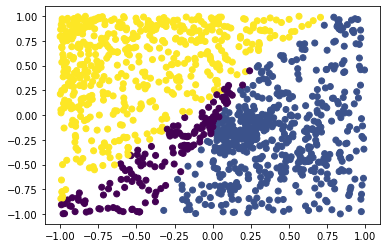

1000 0.895


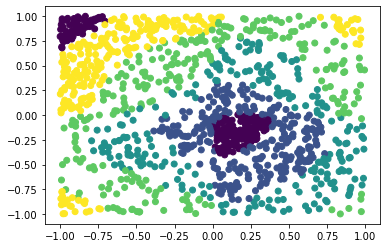

2000 0.909


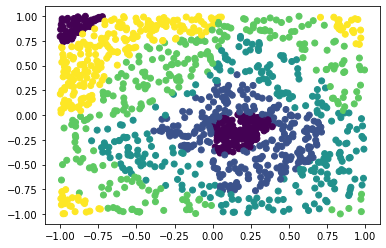

3000 0.888


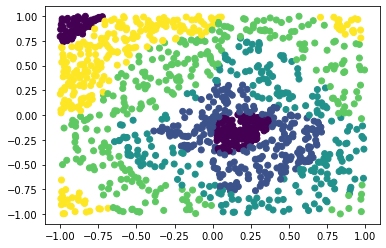

4000 0.9005


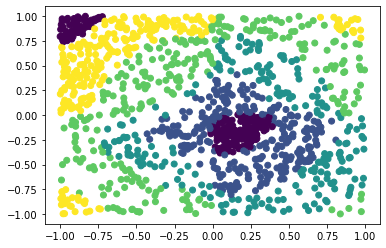

5000 0.8905


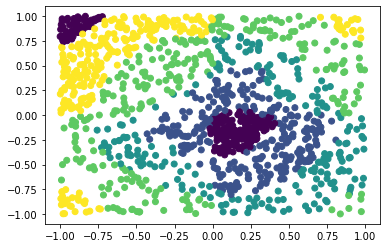

6000 0.9045


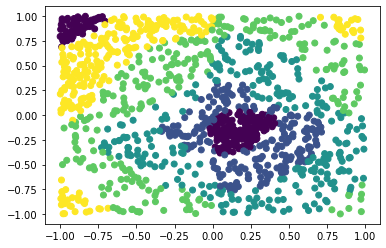

7000 0.9


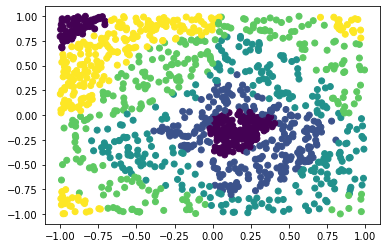

8000 0.888


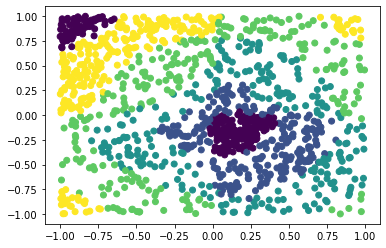

9000 0.8975


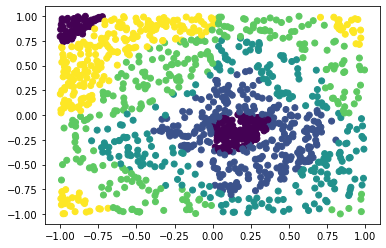

10000 0.9105


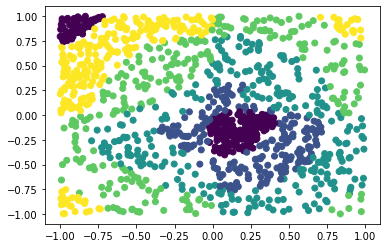

11000 0.8965


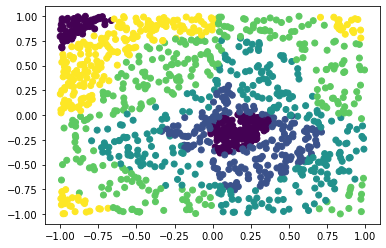

KeyboardInterrupt: 

In [37]:
df_train, df_test = pd.read_csv("../mio1/classification/rings5-regular-training.csv"), pd.read_csv("../mio1/classification/rings5-regular-test.csv")
X_full_train, X_full_test = np.asarray(df_train.loc[:,("x","y")])/100, np.asarray(df_test.loc[:, ("x","y")]) / 100
y_full_train, y_full_test = np.asarray(df_train["c"]), np.asarray(df_test["c"])
encoder = OneHotEncoder(sparse = False)
y_full_train = encoder.fit_transform(y_full_train.reshape(-1, 1))
y_full_test = encoder.transform(y_full_test.reshape(-1, 1))
dataloader = DataLoader(X_full_train,y_full_train, batch_size=100)

layers = [
    LinearLayer(2,5, dist="normal", var="Lecun"),
    SELU(),
    LinearLayer(5, 5, dist="normal", var="Lecun"),
    SELU(),
    LinearLayer(5, 5, dist="normal", var="Lecun"),
    Softmax(),

]
loss = CrossEntropyLoss()
net = MLP(layers)
optim = Adam(net.layers, lr=0.1)
for epoch in range(10**6):
    for (X,y) in dataloader:
        y_hat = net(X)
        err = loss(y,y_hat)
        gradient = loss.derriv()
        net.backward(gradient)
        optim.step()
    if not epoch % 1000:
        plt.cla()
        print(epoch, f1_score(np.argmax(y_full_test, axis=1), np.argmax(net(X_full_test), axis = 1), average = "micro") )
        plt.scatter(X_full_train[:,0], X_full_train[:,1], c= np.argmax(net(X_full_train), axis = 1))
        plt.show()

0 0.5255


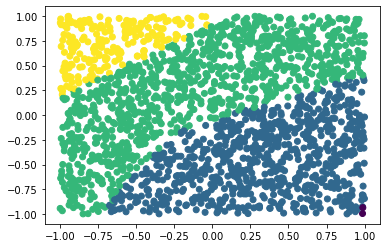

1000 0.889


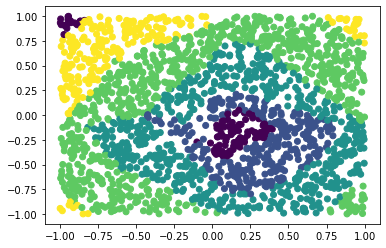

2000 0.898


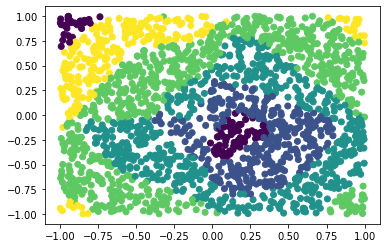

3000 0.916


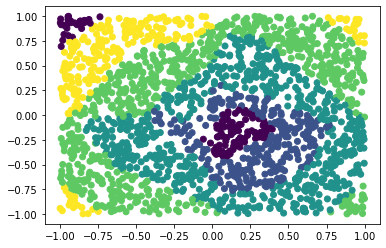

4000 0.8915


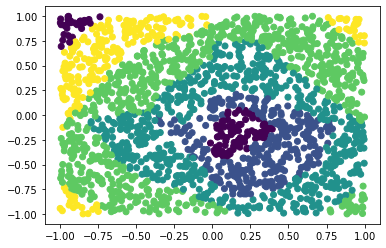

5000 0.911


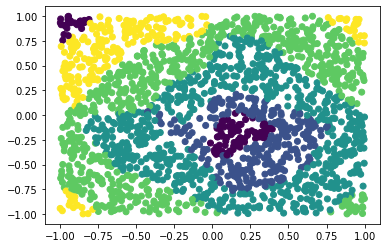

KeyboardInterrupt: 

In [38]:
df_train, df_test = pd.read_csv("../mio1/classification/rings5-regular-test.csv"), pd.read_csv("../mio1/classification/rings5-regular-test.csv")
X_full_train, X_full_test = np.asarray(df_train.loc[:,("x","y")])/100, np.asarray(df_test.loc[:, ("x","y")]) / 100
y_full_train, y_full_test = np.asarray(df_train["c"]), np.asarray(df_test["c"])
encoder = OneHotEncoder(sparse = False)
y_full_train = encoder.fit_transform(y_full_train.reshape(-1, 1))
y_full_test = encoder.transform(y_full_test.reshape(-1, 1))
dataloader = DataLoader(X_full_train,y_full_train, batch_size=100)

layers = [
    LinearLayer(2,5, dist="normal", var="He"),
    PReLU(),
    LinearLayer(5, 5, dist="normal", var="He"),
    PReLU(),
    LinearLayer(5, 5, dist="normal", var="He"),
    Softmax()

]
loss = CrossEntropyLoss()
net = MLP(layers)
optim = Adam(net.layers, lr=0.1)
for epoch in range(10**6):
    for (X,y) in dataloader:
        y_hat = net(X)
        err = loss(y,y_hat)
        gradient = loss.derriv()
        net.backward(gradient)
        optim.step()
    if not epoch % 1000:
        plt.cla()
        print(epoch, f1_score(np.argmax(y_full_test, axis=1), np.argmax(net(X_full_test), axis = 1), average = "micro") )
        plt.scatter(X_full_train[:,0], X_full_train[:,1], c= np.argmax(net(X_full_train), axis = 1))
        plt.show()

In [41]:
net.layers[1].get_parameters()

{'alpha': array(0.28995411)}

In [43]:
net.layers[3].get_parameters()

{'alpha': array(-0.27560161)}